# Transfer Learning session
<em>Instructor:</em> Soufiane Mourragui
<br/>
<em>Contact: </em>s.mourragui@nki.nl & @souf_mourra

## Introduction
Standard machine learning approaches rely on the idea that the data used for prediction (<em>test</em> or <em>evaluation</em> set) comes from the same distribution as the data used for training the model. Unfortunately, <b>this is rarely the case</b> and predictive models are often trained on a dataset that significantly differs from the dataset used for prediction (e.g. in the clinic).
<br/>
Such behaviors has already led to several failures in predictive modelling:
<ul>
    <li> Amazon's program to automate CV pre-screening process turned out to favor male profiles over women (2018, <a href="https://www.bbc.com/news/technology-45809919">source</a>).
    <li> Face-recognition programs struggles to recognize minorities (2019, <a href="https://www.wired.com/story/best-algorithms-struggle-recognize-black-faces-equally/">source</a>).
    <li> On a lighter note: AI systems for ball-tracking confuses the ball with the referee's head (2020, <a href="https://www.diyphotography.net/ai-camera-thinks-bald-referees-head-is-a-soccer-ball/">source</a>)
</ul>
There is therefore a need to correct the source (training) and target (test) datasets to help the predictive model focus on the generalizable information.

## Different approaches
Different approaches exist for solving this problem, see <a href="https://ieeexplore.ieee.org/abstract/document/8861136">[Kouw et al 2019]</a> for a comprehensive review. Roughly speaking, these can be divided into the following categories, depending on data-availabilities.

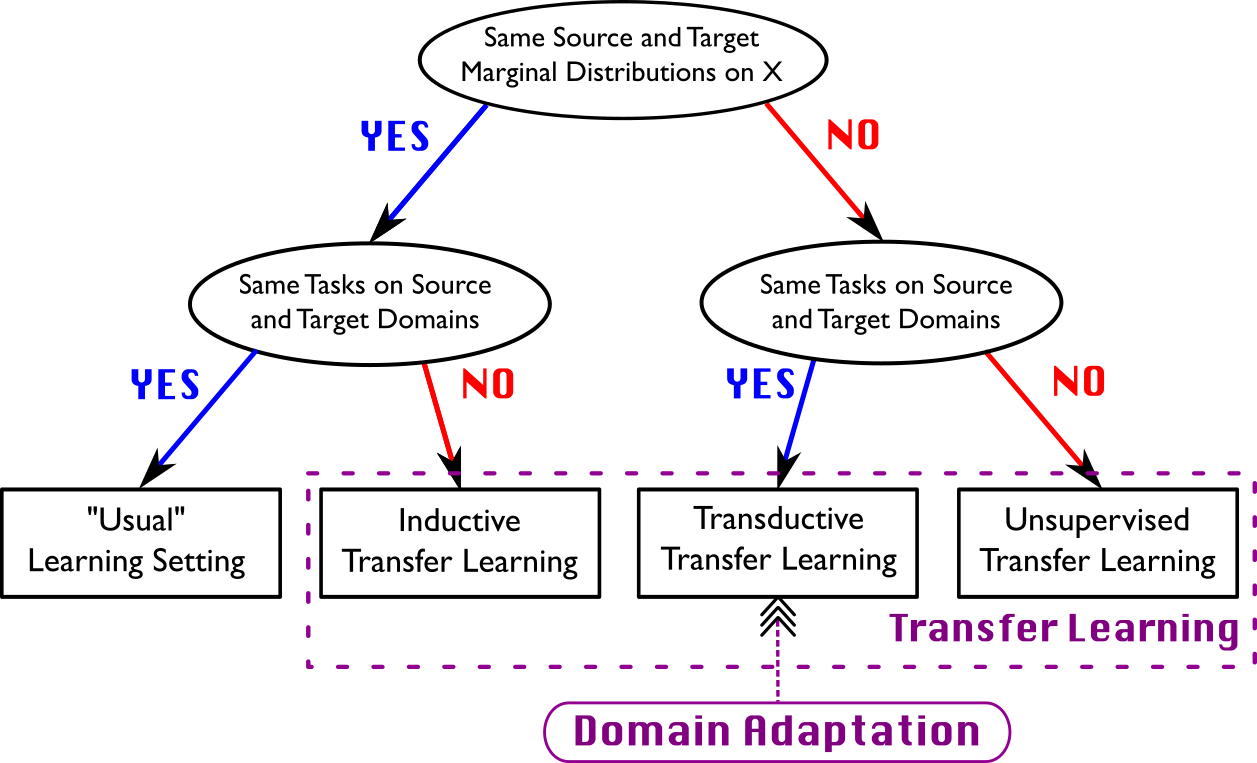

In [1]:
from IPython.display import Image
Image(filename='images/transfer_learning.png')

<b>Inductive transfer learning</b> corresponds to the case where the source and target data comes from the same distribution (e.g. images from the streets of Amsterdam on a sunny day) but the prediction task is different (e.g. in source we predict the number of cars, in target the number of bikes).
<br/><br/>
<b>Transductive transfer learning</b> or <b>domain adaptation</b> corresponds to the case where the task is the same (e.g. in both source and target we want to predict the number of cars in the stret) but the source and target data comes from different images (e.g. images from Amsterdam in source, and from Paris in target).
<br/><br/>
<b>Unsupervised transfer learning</b> finally corresponds to the case where the task and the domains are different. This is the most challenging ones.

We will here focus on <b>domain adaptation</b> in the case of drug response prediction in cancer.

## Problem: predicting drug response in patient derived xenografts (PDXs) from cell line models

Cell line models are versatile and useful models to study the mechanisms of drug response. However, they do not faithfully mimic the biological processes found in-vivo which makes the translation of findings difficult. We here study the drug response prediction problem and try to predict the response in patient derived xenografts (PDXs) using as training data the drug response of cell lines. We will focus on Gemcitabine.
<br/><br/>
<b>Data</b>
- GDSC for cell lines, with drug response measured as AUC (Area Under the drug response Curve).
- PDXE for the patient derived xenografts, with drug response measured as Best Average Response.

## Import package

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from transact.TRANSACT import TRANSACT
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sns.set_style("whitegrid")
sns.set_context('paper')

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.utils.data as Data

## Load data
### Gene expression (in the forms of FPKMs)

In [3]:
GDSC_file = '../data/FPKM_all_GDSC.csv'
GDSC_FPKM_df = pd.read_csv(GDSC_file, index_col=0)

PDXE_file = '../data/FPKM_all_PDXE.csv'
PDXE_FPKM_df = pd.read_csv(PDXE_file, index_col=0)

GDSC_FPKM_df = pd.DataFrame(StandardScaler(with_mean=True, with_std=True).fit_transform(GDSC_FPKM_df),
                            index=GDSC_FPKM_df.index, 
                            columns=GDSC_FPKM_df.columns)
PDXE_FPKM_df = pd.DataFrame(StandardScaler(with_mean=True, with_std=True).fit_transform(PDXE_FPKM_df),
                            index=PDXE_FPKM_df.index, 
                            columns=PDXE_FPKM_df.columns)

### Drug response
Drug response is measured as AUC for cell lines (GDSC) and as Best Average Response for patient derived xenografts (PDXs).

In [4]:
GDSC_response_file = '../data/response_GDSC_Gemcitabine.csv'
GDSC_response_df = pd.read_csv(GDSC_response_file, index_col=0)

PDXE_response_file = '../data/response_PDXE_gemcitabine-50mpk.csv'
PDXE_response_df = pd.read_csv(PDXE_response_file, index_col=0)

In [5]:
GDSC_FPKM_df.shape

(1047, 1780)

## Without domain adaptation
We here train a deep neural network on cell lines and predict the response in PDXs. We propose this architecture after a 5-fold cross-validation on GDSC to select the neural network with the largest expressivity.

### Training on GDSC

In [58]:
input_dropout = 0.1
hidden_dropout = 0.5
weight_decay = 0.0001
learning_rate = 0.0005
activation = torch.nn.Tanh
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16
n_epochs = 100

net = torch.nn.Sequential(
    torch.nn.Dropout(input_dropout),
    torch.nn.Linear(GDSC_FPKM_df.shape[1], 252),
    activation(),
    torch.nn.Dropout(hidden_dropout),
    torch.nn.Linear(252, 252),
    activation(),
    torch.nn.Dropout(hidden_dropout),
    torch.nn.Linear(252, 1)
)

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
loss_func = torch.nn.MSELoss()

In [59]:
GDSC_response_samples = GDSC_response_df.index.get_level_values(0)
X = GDSC_FPKM_df.loc[GDSC_response_samples].values.astype(np.float32)
y = GDSC_response_df.loc[GDSC_response_samples]['AUC'].values.astype(np.float32)
data = TensorDataset(torch.Tensor(X), torch.Tensor(y))
train_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

In [60]:
# Train on whole dataset
loss_values_train = []

rescale_output = lambda x: x.detach().numpy().flatten()

for epoch in range(n_epochs+1):
    # Training
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        net.train()
        y_predict_train = net(x_batch)
        loss = loss_func(y_predict_train, y_batch)
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
        loss_values_train.append(loss)

/home/s.mourragui/.conda/envs/oncode_mc/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### Testing

In [62]:
net.eval()
PDXE_response_samples = PDXE_response_df.index.get_level_values(0)
X_target = torch.Tensor(PDXE_FPKM_df.loc[PDXE_response_samples].values)
PDXE_non_adapted_prediction = net(X_target).detach().numpy().flatten()
PDXE_uncorrected_corr = scipy.stats.spearmanr(PDXE_non_adapted_prediction,
                                              PDXE_response_df.values.flatten())
print(PDXE_uncorrected_corr)

SpearmanrResult(correlation=-0.026330532212885158, pvalue=0.8806525045445801)


## Domain-adaptation
We will here use TRANSACT to correct the signal before feeding it into a complex model.

In [33]:
kernel = 'rbf'
kernel_params = {'gamma': 10**(-3.5)}

n_components = {
    'source': 70,
    'target': 50
}

In [34]:
TRANSACT_clf = TRANSACT(kernel=kernel,
                        kernel_params=kernel_params,
                        n_components=n_components,
                        n_jobs=30, 
                        verbose=1)
TRANSACT_clf.fit(GDSC_FPKM_df.values, PDXE_FPKM_df.values)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.0s finished


### Cosine similarity matrix
To grasp the difference between cell-lines and tumors, let's visualise the similarity between cell lines Non Linear Principal Components (NLPCs) and the patient derived xenografts NLPCs. This is quantified by the cosine similarity matrix that compares each cell line NLPCs to each PDX NLPCs. In an ideal scenario where the two domains match, we would have a diagonal matrix, suggesting that both datasets are supported by the same variance.

Text(0.5, 32.7, 'PDX NLPCs')

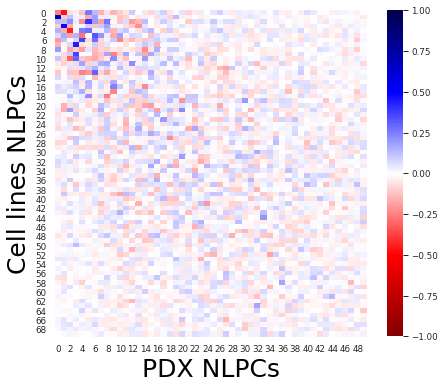

In [35]:
plt.figure(figsize=(7,6))
sns.heatmap(TRANSACT_clf.principal_vectors_.cosine_similarity_, cmap='seismic_r', center=0, vmax=1, vmin=-1)
plt.ylabel('Cell lines NLPCs', fontsize=25, color='black')
plt.xlabel('PDX NLPCs', fontsize=25, color='black')

### Quality of alignment
We use the notion of principal vectors (PVs) to align these NLPCs and find pairs of vectors (one from source, one from target) as close as possible to one another. The cosine similarity matrix must be more diagonal then ?

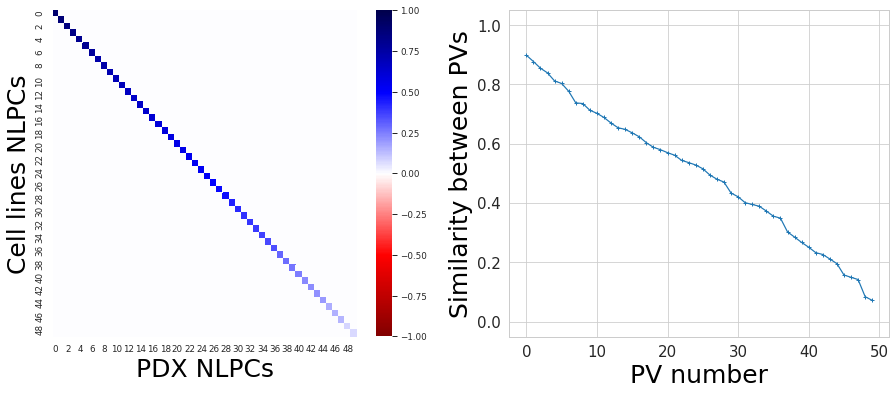

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

# Cosine similarity
sns.heatmap(np.diag(np.cos(TRANSACT_clf.principal_vectors_.canonical_angles)),
            cmap='seismic_r', center=0, vmax=1, vmin=-1, ax=axes[0])
axes[0].set_ylabel('Cell lines NLPCs', fontsize=25, color='black')
axes[0].set_xlabel('PDX NLPCs', fontsize=25, color='black')

axes[1].plot(np.cos(TRANSACT_clf.principal_vectors_.canonical_angles), marker='+')
axes[1].set_ylabel('Similarity between PVs', fontsize=25, color='black')
axes[1].set_xlabel('PV number', fontsize=25, color='black')
axes[1].tick_params(axis='both', labelsize=15)
axes[1].set_ylim(-0.05, 1.05)
plt.show()

### Training a predictor on cell lines
We here selct the PVs with similarity above 0.5 ($n_{pv}\approx 20$) and train a predictor.

In [51]:
TRANSACT_clf.fit(GDSC_FPKM_df.values, PDXE_FPKM_df.values, n_pv=20, with_interpolation=True)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 101 out of 101 | elapsed:    1.0s finished


In [52]:
TRANSACT_clf.fit_predictor(X, y)

Fitting 10 folds for each of 238 candidates, totalling 2380 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 280 tasks      | elapsed:    0.9s
[Parallel(n_jobs=30)]: Done 1660 tasks      | elapsed:    2.4s
[Parallel(n_jobs=30)]: Done 2380 out of 2380 | elapsed:    2.7s finished


### Applying it on PDXs

In [71]:
PDXE_adapted_corr = scipy.stats.spearmanr(TRANSACT_clf.predict(X_target), PDXE_response_df.values.flatten())

## Comparing the two predictions

Text(0, 0.5, 'Correlation on PDXs')

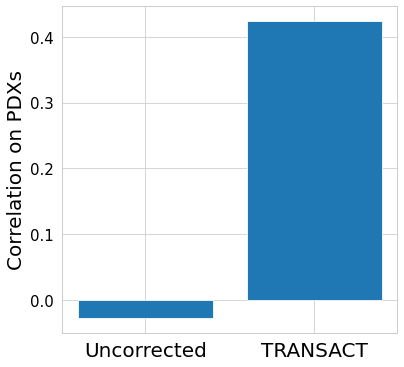

In [89]:
plt.figure(figsize=(6,6))
plt.bar(x=[0,1], height=[PDXE_uncorrected_corr[0], PDXE_adapted_prediction[0]])
plt.xticks([0,1], ['Uncorrected', 'TRANSACT'], fontsize=20, color='black')
plt.yticks(fontsize=15, color='black')
plt.ylabel('Correlation on PDXs', fontsize=20, color='black')

## What we did not touch upon
We showed an example of domain adaptation applied to genomics. There are various other applications and transfer learning methods that exist out there. A few interesting examples:
<ul>
    <li> <b>Neural network pre-training</b>: Once a neural network has been trained on a source dataset, it can be interesting to tune it on the target dataset. This only applies if some labelled data is available on the test set.
    <li> <b>Sample reweighting</b>: Another strategy consists in weighting source samples according to how well they fit inside the target data. For instance, a source sample with a lot of close target samples will be down-weighted -- in the meantime, a source samples without any close correspondance in the target data will be down-weighted.
    <li> <b>Domain adaptation theory</b>:
</ul>

## References
- <a href="https://ieeexplore.ieee.org/abstract/document/8861136">A review of domain adaptation without target labels </a>, Kouw et al 2019, TPAMI. 